In [1]:
# basics
import numpy as np
import pandas as pd
import datetime
import re
import os,glob

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);

np.seterr(divide = 'ignore');


In [2]:
# load data into datawrapper classes
measure_data = mc.COVID19_measures(download_data = False, measure_level = 2, only_first_dates = True, expand_measure_names = True)
jhu_data     = cdc.CoronaData(download_data = False)

# remove and rename countries to match the JFU database and the measures database
measure_data.RemoveCountry('Diamond Princess')
measure_data.RenameCountry('France (metropole)', 'France')
measure_data.RenameCountry('South Korea', 'Korea, South')
measure_data.RenameCountry('Czech Republic', 'Czechia')


In [3]:
def date2vector(implementdate, start = '22/1/20', end = None, shiftdays = 0):
    # generate vector of 0s and 1s when measure is implemented or not
    starttime     = datetime.datetime.strptime(start,         '%d/%m/%y')
    if end is None:
        endtime   = datetime.datetime.today()
    else:
        endtime   = datetime.datetime.strptime(end,           '%d/%m/%y')
    implementtime = datetime.datetime.strptime(implementdate, '%d/%m/%Y')
    
    totaldays   = (endtime       - starttime).days
    measuredays = (implementtime - starttime).days
    
    vec         = np.zeros(totaldays)
    vec[min(measuredays+shiftdays,len(vec)-1):] = 1
    
    return vec


def ConvertDateFormat(date):
    m,d,y = date.split('/')
    return '{:02d}/{:02d}/{:02d}'.format(int(d),int(m),int(y))


def CleanUpMeasureName(measurename):
    # regression model formula can't contain special characters
    return ''.join([mn.capitalize() for mn in measurename.replace(',','').replace('-','').replace('/','').split(' ')])


def GetMeasureIDs(countrylist = None, measure_level = 2, mincount = None, extend_measure_names = False):
    if countrylist is None:
        countrylist = measure_data.countrylist # use ALL countries
    
    measurelist = {}
    
    # get all restrictions from countries
    for country in countrylist:
        country_measures = measure_data.CountryData(country, measure_level = 2, extend_measure_names = extend_measure_names)
        for measurename, initialdata in country_measures.items():
            if not measurename in measurelist.keys():
                measurelist[measurename] = 0
            measurelist[measurename] += 1
    
    if not mincount is None:
        # rebuild dict with restrictions
        measurelist = {k:v for k,v in measurelist.items() if v >= mincount}

    return measurelist


def SmoothTrajectories3(traj):
    if len(traj) > 3:
        newtraj       = np.zeros(len(traj))
        newtraj[0]    = (             2 * traj[0]    + traj[1] )/3.
        newtraj[1:-1] = (traj[0:-2] + 2 * traj[1:-1] + traj[2:])/4.
        newtraj[-1]   = (traj[-2]   + 2 * traj[-1]             )/3.
        return newtraj
    else:
        return traj


def GetCountryTrajectories(countrylist = None, data = 'Confirmed', startcases = None, maxlen = None, smooth = False):
    if countrylist is None:
        countrylist = jhu_data.countrylist
    
    trajectories = {}
    for country in [c for c in countrylist if c in jhu_data.countrylist]:
        ctraj = np.array(jhu_data.CountryData(country)[data], dtype = np.float)
        starttraj = 0
        if not startcases is None:
            starttraj = np.argmax(ctraj >= startcases)
            ctraj = ctraj[starttraj:]
            if not maxlen is None:
                ctraj = ctraj[:min(maxlen,len(ctraj))]
        trajectories[country] = {}
        if smooth:
            ctraj = SmoothTrajectories3(ctraj)
        trajectories[country]['traj'] = ctraj
        trajectories[country]['startdate'] = ConvertDateFormat(jhu_data.CountryData(country)['Date'][starttraj])
    
    return trajectories

        
def GetRegressionDF(countrylist = None, measure_level = 2, shiftdays = 0, verbose = False, maxlen = None, smooth = None):
    # construct pd.DataFrame used for regression
    
    # get trajectories and measure list for all countries in 'countrylist'
    trajectories         = GetCountryTrajectories(countrylist = countrylist, data = 'Confirmed', startcases = 30, maxlen = maxlen, smooth = smooth)
    measureIDs           = measure_data.MeasureList(countrylist = countrylist, measure_level = 2, mincount = 5)
    cleaned_measurelist  = {CleanUpMeasureName(mn):count for mn,count in measureIDs.items()}
    regressionDF         = None
    
    if verbose:
        print(measureIDs)
    
    for country in trajectories.keys():
        if country in measure_data.countrylist:

            # ********************************************
            # change observable to regress here:
            observable                  = np.diff(np.log(trajectories[country]['traj']))
            obslen                      = len(observable)
            # ********************************************
            
            DF_country = measure_data.ImplementationTable(country           = country,
                                                        measure_level     = 2,
                                                        startdate         = trajectories[country]['startdate'],
                                                        shiftdays         = shiftdays,
                                                        maxlen            = obslen,
                                                        clean_measurename = True)
            
            for measurename in DF_country.columns:
                if measurename not in measureIDs.keys():
                    DF_country.drop(labels = measurename, axis = 'columns')
            
            DF_country['Country']    = country
            DF_country['Observable'] = observable

            
            if not (np.isnan(DF_country['Observable']).any() or np.isinf(DF_country['Observable']).any()):

                if regressionDF is None:
                    regressionDF = DF_country
                else:
                    regressionDF = pd.concat([regressionDF,DF_country], ignore_index = True, sort = False)
    
    # not implemented measures should be NaN values, set them to 0
    regressionDF.fillna(0, inplace = True)
    
    return regressionDF, cleaned_measurelist



def GetCountryMasks(regrDF):
    countrylist = list(regrDF['Country'].unique())
    maskdict = {}
    for country in countrylist:
        mask = list(regrDF['Country'] == country)
        maskdict[country] = mask
    return maskdict


In [4]:
regrDF   = {}
maxshift = 10
for shiftdays in range(0, maxshift + 1):
    print('shiftdays = {}'.format(shiftdays))
    regrDF[shiftdays], measurelist = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, smooth = True)


shiftdays = 0


/usr/lib64/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/lib64/python3.7/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


shiftdays = 1
shiftdays = 2
shiftdays = 3
shiftdays = 4
shiftdays = 5
shiftdays = 6
shiftdays = 7
shiftdays = 8
shiftdays = 9
shiftdays = 10


data/results_smallshift_200413_0.csv
data/results_smallshift_200413_2.csv
data/results_smallshift_200413_1.csv
data/results_largeshift_200413_0.csv


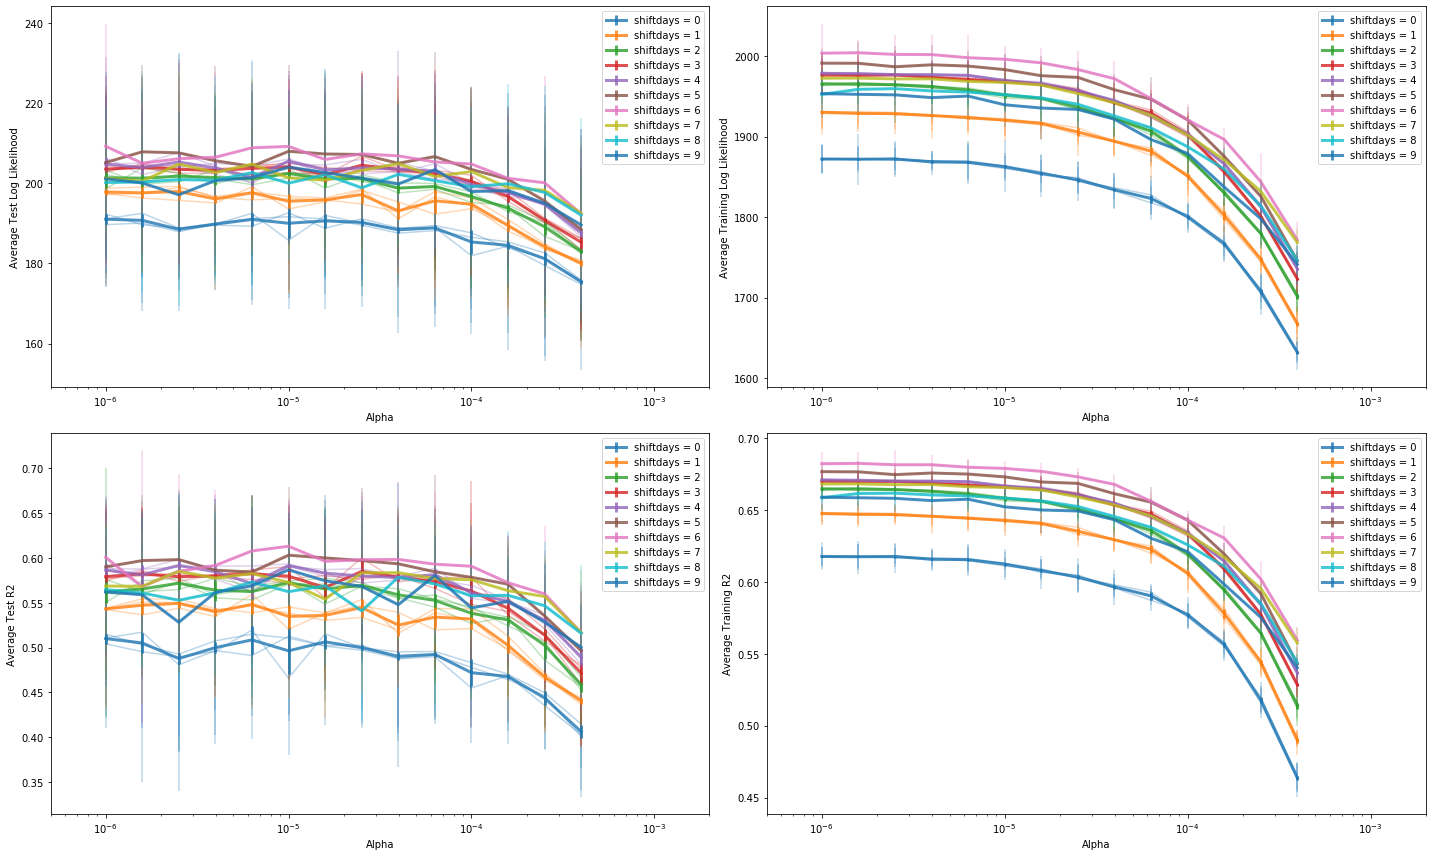

In [5]:
# various sets of calculations
filelist_nomaxlen  =  [ 'data/results_Xval_rnd10_200411_4.csv','data/results_Xval_rnd10_200411_5.csv'] \
                    + ['data/results_Xval_200412_{}.csv'.format(i) for i in range(10)] \
                    + ['data/results_smallshift_200413_{}.csv'.format(i) for i in range(10)]

filelist_maxlen    = ['results_Xval_maxlen40_200412_{}.csv'.format(i) for i in range(10)]

filelist_nocountry = glob.glob('data/*nocountry*_?.csv')

filelist_new = glob.glob('data/*200413*.csv')


# plot test errors
markerlist = ['o','x','v','^','p','P','h','D','s','X','>','<']
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]
alldata    = []
resDF      = None

fig,axis   = plt.subplots(2,2,figsize = (20,12))
ax         = axis.flatten()

for i,fn in enumerate(filelist_new):
    if os.path.exists(fn):
        print(fn)
        alldata.append(pd.read_csv(fn))

        shiftdaylist = np.array(alldata[i]['shiftdays'].unique(),dtype=np.int)
        alphalist    = alldata[i]['alpha'].unique()
        
        # compute averages and stddev with pandas
        curavg = alldata[i].groupby(['shiftdays','alpha'], as_index = False).agg(
            { 'Loglike Test':['mean','std'],
              'Loglike Training':['mean','std'],
              'R2 Test': ['mean','std'],
              'R2 Training': ['mean','std']
            })
        
        # rename columns in new DF
        curavg.columns = ['shiftdays','alpha',
                          'Loglike Test','Loglike Test Std',
                          'Loglike Training','Loglike Training Std',
                          'R2 Test','R2 Test Std',
                          'R2 Training','R2 Training Std'
                         ]
        # add more columns to identify results
        curavg['filename']  = fn
        curavg['iteration'] = i

        if resDF is None: resDF = pd.DataFrame(curavg)
        else:             resDF = pd.concat([resDF,curavg])
            
        for shiftdays in curavg['shiftdays'].unique():
            boolidx = np.array(curavg['shiftdays'] == shiftdays)
            ax[0].errorbar(alphalist, curavg[boolidx]['Loglike Test'],     yerr = curavg[boolidx]['Loglike Test Std'],     c = colornames[int(shiftdays) % len(colornames)], alpha = .3)
            ax[1].errorbar(alphalist, curavg[boolidx]['Loglike Training'], yerr = curavg[boolidx]['Loglike Training Std'], c = colornames[int(shiftdays) % len(colornames)], alpha = .3)
            ax[2].errorbar(alphalist, curavg[boolidx]['R2 Test'],          yerr = curavg[boolidx]['R2 Test Std'],          c = colornames[int(shiftdays) % len(colornames)], alpha = .3)
            ax[3].errorbar(alphalist, curavg[boolidx]['R2 Training'],      yerr = curavg[boolidx]['R2 Training Std'],      c = colornames[int(shiftdays) % len(colornames)], alpha = .3)


# compute average and plot it
alphalist    = resDF['alpha'].unique()
totalavg     = resDF.groupby(['shiftdays','alpha'], as_index = False).agg(
                            { 'Loglike Test':['mean','std'],
                              'Loglike Training':['mean','std'],
                              'R2 Test': ['mean','std'],
                              'R2 Training': ['mean','std']
                            })
        
# rename columns in new DF
totalavg.columns = ['shiftdays','alpha',
                    'Loglike Test','Loglike Test Std',
                    'Loglike Training','Loglike Training Std',
                    'R2 Test','R2 Test Std',
                    'R2 Training','R2 Training Std'
                     ]



for shiftdays in totalavg['shiftdays'].unique():
    boolidx = np.array(totalavg['shiftdays'] == shiftdays)
    ax[0].errorbar(alphalist, totalavg[boolidx]['Loglike Test'],     yerr = totalavg[boolidx]['Loglike Test Std'],     c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))
    ax[1].errorbar(alphalist, totalavg[boolidx]['Loglike Training'], yerr = totalavg[boolidx]['Loglike Training Std'], c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))
    ax[2].errorbar(alphalist, totalavg[boolidx]['R2 Test'],          yerr = totalavg[boolidx]['R2 Test Std'],          c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))
    ax[3].errorbar(alphalist, totalavg[boolidx]['R2 Training'],      yerr = totalavg[boolidx]['R2 Training Std'],      c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))

for i in range(4):
    ax[i].set_xlim([1e-6/2,2e-3])
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'Alpha')
    ax[i].legend()
    
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_ylabel('Average Training Log Likelihood')
ax[2].set_ylabel('Average Test R2')
ax[3].set_ylabel('Average Training R2')

#ax[0].set_ylim([1.12,1.34])
#ax[1].set_ylim([1.12,1.34])
#ax[2].set_ylim([.45,.63])
#ax[3].set_ylim([.45,.63])

fig.tight_layout()
plt.savefig('loglikelihood_longrun.pdf')


In [ ]:
allres = pd.read_csv('results_doublealpha_200412_3.csv')

In [ ]:
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

g = allres.groupby(['shiftdays','alpha','alphacountry'], as_index = False)['Loglike Test'].mean()
for shiftdays in g['shiftdays'].unique():
    print(shiftdays)
    for alphac in g['alphacountry'].unique():
        alpha = np.array(g[(g['shiftdays']==shiftdays)&(g['alphacountry']==alphac)]['alpha'])
        llt   = np.array(g[(g['shiftdays']==shiftdays)&(g['alphacountry']==alphac)]['Loglike Test'])
        plt.plot(alpha,llt,marker = '.',c = colornames[int(shiftdays)%len(colornames)],label = 's = {:.0f}'.format(shiftdays))
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
countrylist = list(regrDF6['Country'].unique())
trajlen = [len(regrDF6[regrDF6['Country'] == country]) for country in countrylist]

#for x in zip(countrylist,trajlen):
#    print(x)
plt.hist(trajlen, range=(0,70),bins=71)
plt.show()

In [ ]:
sampleassignment = pd.read_csv('samplevec_Xval_200412.csv')
for i in range(10):
    print(i,np.sum(sampleassignment['rep{}'.format(i)]==i))

In [84]:
# ****************************************************************************
# **  define final model parameters here as tuples (s,alpha) *****************
# ****************************************************************************
final_meta_parameters = [(6,1e-3),(6,1e-4),(6,1e-5),(7,1e-3),(7,1e-4),(7,1e-5),(8,1e-3),(8,1e-4),(8,1e-5)]
# ****************************************************************************



formula = 'Observable ~ C(Country) + ' + ' + '.join(measurelist)
model_final   = []
results_final = []
for shiftdays,alpha in final_meta_parameters:
    print('computing model ({},{})'.format(shiftdays,alpha))
    model_final.append(smf.ols(formula = formula, data = regrDF[shiftdays]))
    results_final.append(model_final[-1].fit_regularized(alpha = alpha, L1_wt = 1))

intercept     = [results_final[i].params['Intercept'] for i in range(len(final_meta_parameters))]
countrylist   = [paramname.split('.')[1].split(']')[0] for paramname in results_final[0].params.index if paramname[:3] == 'C(C']

# collect measure names for labels
ml            = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
measure_level_dict = {}
for mn in ml.keys():
    l1,l2 = mn.split(' - ')
    if not l1 in measure_level_dict.keys():
        measure_level_dict[l1] = {}
    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

# amelies colorscheme...                 
colornames = ['gray','#f563e2','#609cff','#00bec4','#00b938','#b79f00','#f8766c']

                 
#colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]


computing model (6,0.001)
computing model (6,0.0001)
computing model (6,1e-05)
computing model (7,0.001)
computing model (7,0.0001)
computing model (7,1e-05)
computing model (8,0.001)
computing model (8,0.0001)
computing model (8,1e-05)


/usr/lib64/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


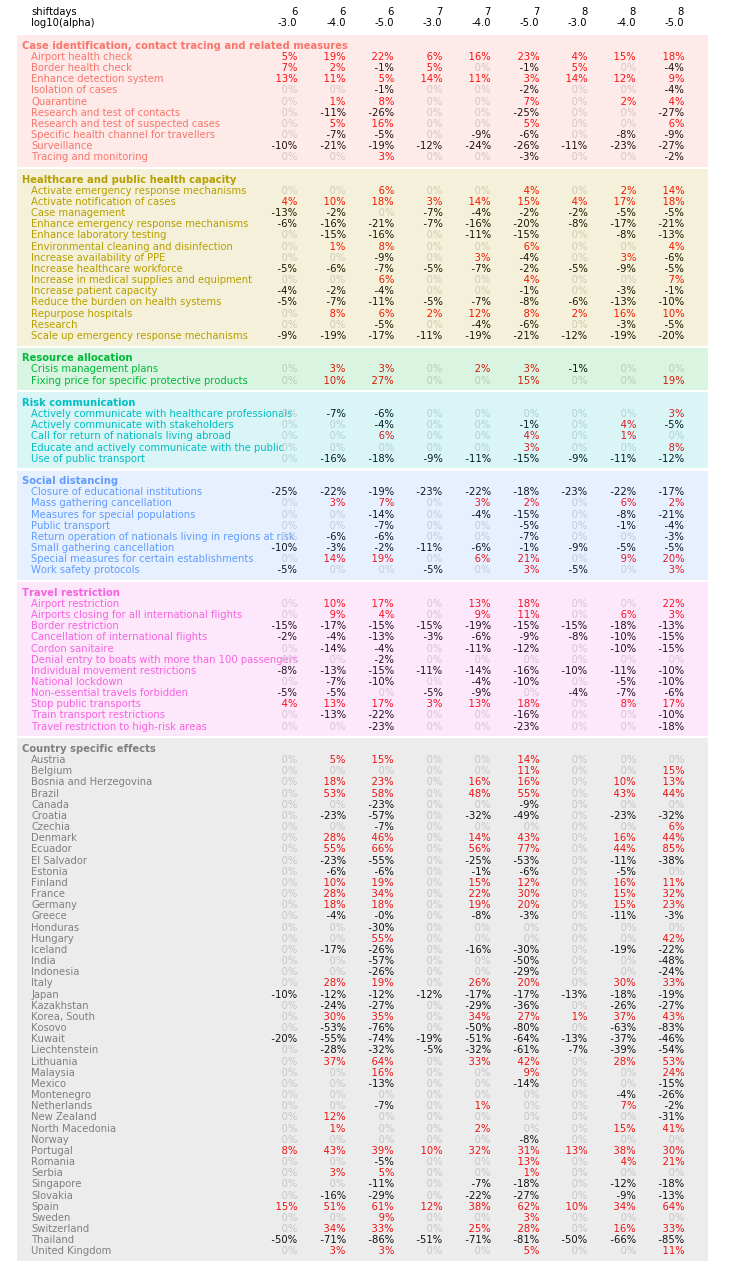

In [85]:
def significanceColor(beta):
    if beta   >  0.00: return 'red'
    elif beta == 0.00: return 'lightgray'
    else:              return 'black'

    
l1list = list(measure_level_dict.keys())
l1list.sort()

fig,ax = plt.subplots(figsize = (13,23))

i = 0
groupcolor = 0

label_x = 1
label_x_header = .6
value_x  = 12
value_dx = 2
boxalpha = .15
ax.annotate('Country specific effects',[label_x_header, len(countrylist)], c = colornames[groupcolor], weight = 'bold' )

background = plt.Rectangle([label_x - .6, i - .65], value_x + (len(final_meta_parameters)-1)*2 + .6, len(countrylist) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
ax.add_patch(background)


for country in countrylist[::-1]:
    ax.annotate(country, [label_x, i], c= colornames[groupcolor])
    for j in range(len(final_meta_parameters)):
        beta_val = results_final[j].params['C(Country)[T.{}]'.format(country)] / intercept[j]
        c = significanceColor(beta_val)
        ax.annotate('{:6.0f}%'.format(beta_val*100),[value_x + j * value_dx, i], c = c, ha = 'right')
    i += 1

groupcolor += 1

i+=2 

for l1 in l1list[::-1]:
    ax.annotate(l1,[label_x_header, i + len(measure_level_dict[l1])], c = colornames[groupcolor], weight = 'bold')
    l2list = list(measure_level_dict[l1].keys())
    l2list.sort()
    
    background = plt.Rectangle([label_x - .6, i - .65], value_x + 2*(len(final_meta_parameters)-1) + .6, len(measure_level_dict[l1]) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
    ax.add_patch(background)
    
    for l2 in l2list[::-1]:
        ax.annotate(l2,[label_x,i],c = colornames[groupcolor])
        for j in range(len(final_meta_parameters)):
            beta_val = results_final[j].params[measure_level_dict[l1][l2]] / intercept[j]
            c = significanceColor(beta_val)
            ax.annotate('{:6.0f}%'.format(beta_val*100),[value_x + j * value_dx, i], c = c, ha = 'right')
        i+=1
    i+=2
    groupcolor += 1
        #print('  {:60s} {:6.3f}'.format(l2,results_final.params[measure_level_dict[l1][l2]]/intercept))

ax.annotate('shiftdays',[label_x,i+1])
ax.annotate('log10(alpha)',[label_x,i])
for j in range(len(final_meta_parameters)):
    ax.annotate('{}'.format(final_meta_parameters[j][0]),               [value_x + j*value_dx,i+1],ha='right')
    ax.annotate('{:.1f}'.format(np.log10(final_meta_parameters[j][1])), [value_x + j*value_dx,i],ha='right')        

ax.set_xlim([0,value_x + 2 * len(final_meta_parameters)])
ax.set_ylim([-1,i+1])
ax.axis('off')
plt.savefig('effects_measures.pdf')


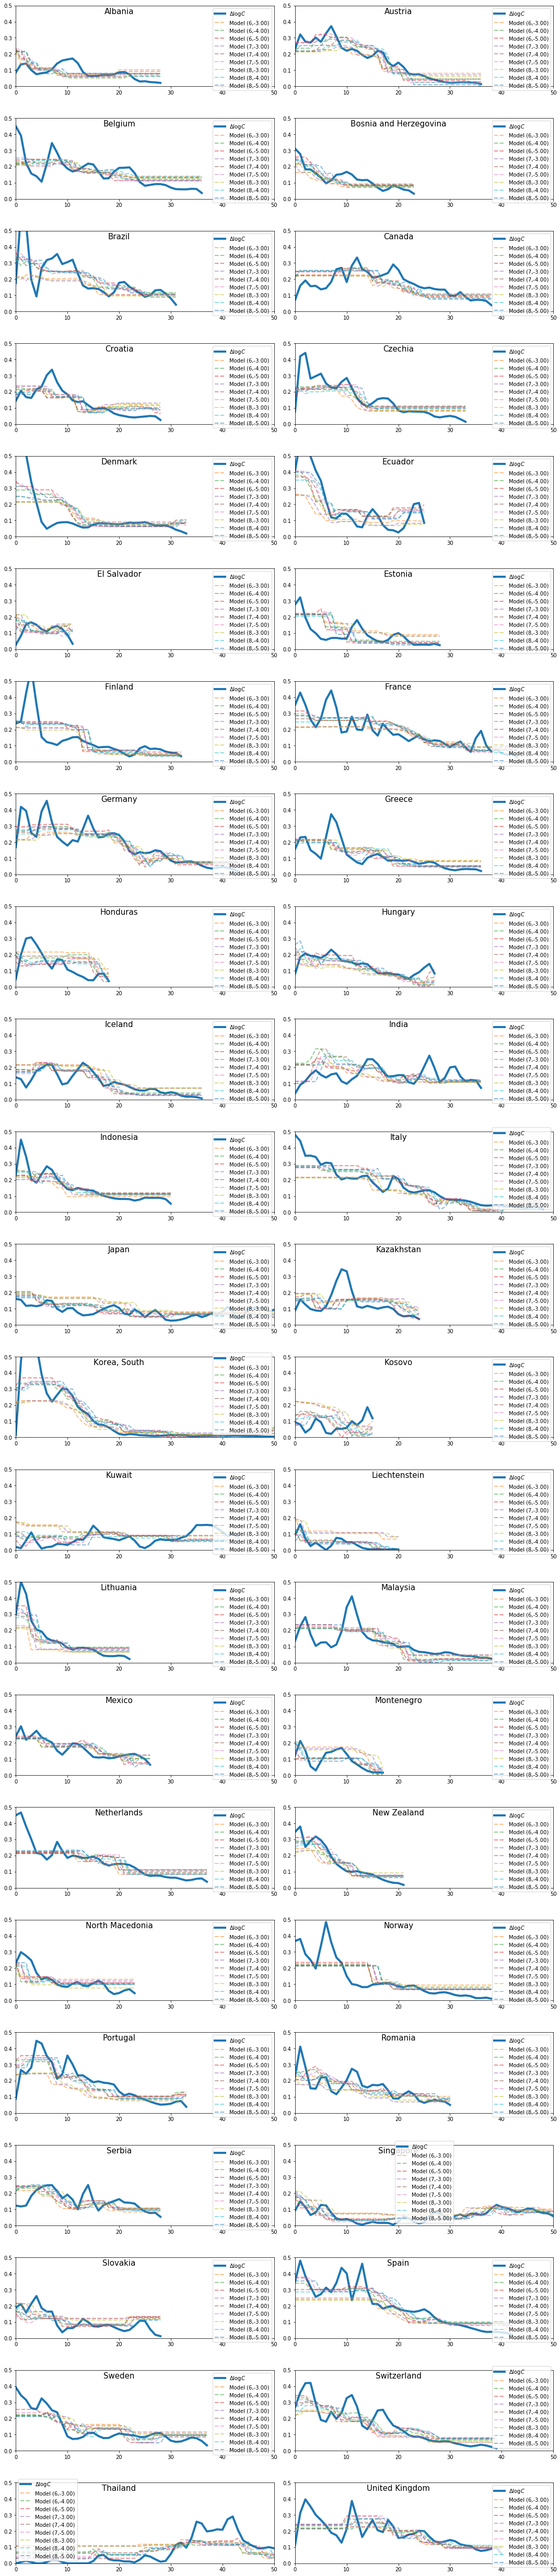

In [86]:
#specialcountries = ['Austria','Germany','Thailand', 'Italy', 'Spain', 'Sweden',
#                    'Japan', 'Hungary', 'France', 'Mexico', 'Netherlands', 'Korea, South']

colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

specialcountries = regrDF[list(regrDF.keys())[0]]['Country'].unique()
cm = GetCountryMasks(regrDF[list(regrDF.keys())[0]])

plotxcount = int(len(specialcountries)/2) + len(specialcountries)%2

fig,ax = plt.subplots(plotxcount,2,figsize = (15,3*plotxcount))
ax = ax.flatten()

for i,country in enumerate(specialcountries):
    for j,(s,alpha) in enumerate(final_meta_parameters):
        if j == 0:
            dlc = np.array(regrDF[s][cm[country]]['Observable'])
            ax[i].plot(dlc, lw = 4, c = colornames[0], label = r'$\Delta \log C$')
        
        pred = results_final[j].predict()[cm[country]]
        ax[i].plot(pred, lw = 2, c = colornames[(j+1)%(len(colornames))], linestyle = '--', label = 'Model ({:.0f},{:.2f})'.format(s,np.log10(alpha)),alpha = .5)
    ax[i].set_ylim([0,.5])
    ax[i].set_xlim([0,50])
    ax[i].annotate(country, [20,.45],ha = 'center',fontsize = 15)
    ax[i].legend()
fig.tight_layout()
plt.savefig('regression_trajectories.pdf')


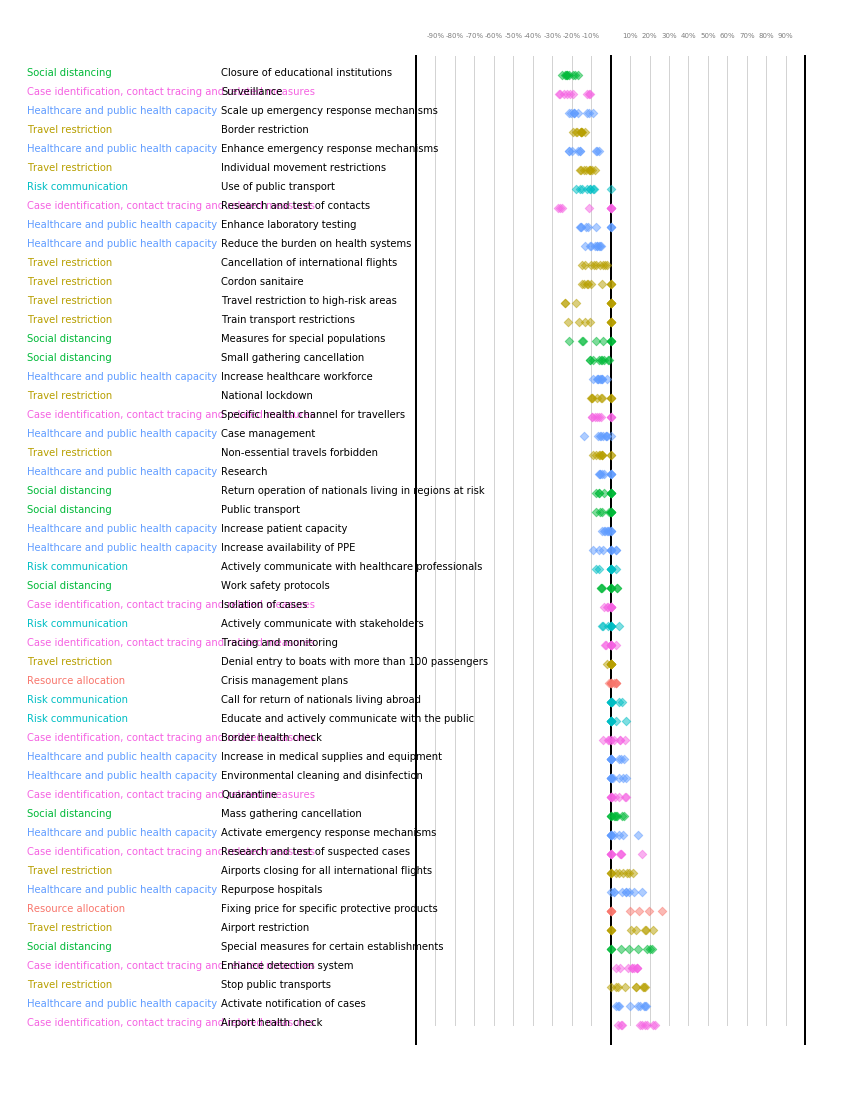

In [107]:
def modelname(index):
    return '({},{})'.format(final_meta_parameters[index][0],final_meta_parameters[index][1])

colornames    = ['#f563e2','#609cff','#00bec4','#00b938','#b79f00','#f8766c']
measurecolors = {l1:col for l1,col in zip(measure_level_dict.keys(),colornames)}
model_count   = len(final_meta_parameters)
intercept     = [np.array(results_final[i].params['Intercept']) for i in range(model_count)]

inverse_mld   = {}
for l1 in measure_level_dict.keys():
    for l2 in measure_level_dict[l1].keys():
        inverse_mld[measure_level_dict[l1][l2]] = (l1,l2)

modelDF       = pd.DataFrame(columns=[modelname(i) for i in range(model_count)])

allparamnames = list(set([mn for i in range(model_count) for mn in results_final[i].params.keys() if mn[:3] != 'C(C']))
allparamnames.remove('Intercept')

for paramname in allparamnames:
    paramvaluedict = {}
    for i in range(model_count):
        paramvaluedict[modelname(i)] = results_final[i].params[paramname]/intercept[i]
    modelDF.loc[paramname] = paramvaluedict
    
modelDF['average'] = modelDF.mean(numeric_only = True, axis = 1)
modelDF.sort_values(by = 'average', inplace = True, ascending = False)

modelDF.to_csv('measure_effects_various_models.csv')

l1_pos = -3
l2_pos = -2

fig,ax = plt.subplots(figsize = (15,20))

for j,(index,values) in enumerate(modelDF.iterrows()):
    ax.annotate(inverse_mld[index][0],[l1_pos,j],c = measurecolors[inverse_mld[index][0]])
    ax.annotate(inverse_mld[index][1],[l2_pos,j])
    betaval = np.array(values)[:-1]
    ax.scatter(betaval,j * np.ones(model_count), c = measurecolors[inverse_mld[index][0]], alpha = .5, marker = 'D')
ax.set_xlim([-3.1,1.2])

for vertline in np.linspace(0,1,num=10,endpoint = False):
    if vertline != 0:
        ax.plot([vertline,vertline],[0,j+1],c = 'lightgray',zorder = -3,lw =1)
        ax.plot([-vertline,-vertline],[0,j+1],c = 'lightgray',zorder = -3,lw =1)
        ax.annotate('-{:.0f}%'.format(vertline*100),[-vertline,j+2],fontsize = 7,c='gray',ha='center')
        ax.annotate('{:.0f}%'.format(vertline*100),[vertline,j+2],fontsize = 7,c='gray',ha='center')
ax.plot([-1,-1],[-1,j+1], lw = 2, c = 'black',zorder = -2)
ax.plot([0,0],[-1,j+1], lw = 2, c = 'black', zorder = -2)
ax.plot([1,1],[-1,j+1], lw = 2, c = 'black', zorder = -2)

ax.axis('off')
plt.savefig('effects_measures_various_models.pdf')



In [ ]:
import pickle

pickle.dump(regrDF, open('pickle/regrDF.pickle','wb'))
pickle.dump(regrDF_test, open('pickle/regrDF_test.pickle','wb'))
pickle.dump(regrDF_train, open('pickle/regrDF_train.pickle','wb'))
pickle.dump(model_excludeC, open('pickle/model_excludeC.pickle','wb'))
pickle.dump(model_singleC, open('pickle/model_singleC.pickle','wb'))


In [ ]:
tmp = 

In [ ]:
filelist_nomaxlen = [ 'results_Xval_rnd10_200411_4.csv',
                      'results_Xval_rnd10_200411_5.csv',
                      'results_Xval_200412_0.csv',
                      'results_Xval_200412_1.csv',
                      'results_Xval_200412_2.csv',
                      'results_Xval_200412_3.csv',
                      'results_Xval_200412_4.csv',
                      'results_Xval_200412_5.csv',
                      'results_Xval_200412_6.csv',
                      'results_Xval_200412_7.csv',
                      'results_Xval_200412_8.csv',
                      'results_Xval_200412_9.csv'
                    ]

filelist_maxlen = ['results_Xval_maxlen40_200412_{}.csv'.format(i) for i in range(10)]

filelist_da = ['results_doublealpha_200412.csv']

markerlist = ['o','x','v','^','p','P','h','D','s','X','>','<']
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]
alldata = []
resDF = None

fig,axis = plt.subplots(2,2,figsize = (20,12))
ax = axis.flatten()
for i,fn in enumerate(filelist_da):
    print(fn)
    if os.path.exists(fn):
        alldata.append(pd.read_csv(fn))

        alphaclist   = alldata[i]['alphacountry'].unique()
        alphalist    = alldata[i]['alpha'].unique()

        for alphac in alphaclist:
            lltest_mean = []
            lltrain_mean = []
            lltest_std = []
            lltrain_std = []
            r2test_mean = []
            r2test_std  = []
            r2train_mean = []
            r2train_std = []
            for alpha in alphalist:
                boolidx = (alldata[i]['alphacountry']==shiftdays) & (alldata[i]['alpha'] == alpha)
                lltest_mean.append (np.mean((alldata[i][boolidx])['Loglike Test'])/153.)
                lltest_std.append  (np.std ((alldata[i][boolidx])['Loglike Test'])/153.)
                lltrain_mean.append(np.mean((alldata[i][boolidx])['Loglike Training'])/(9*153.))
                lltrain_std.append (np.std ((alldata[i][boolidx])['Loglike Training'])/(9*153.))

                r2test_mean.append (np.mean((alldata[i][boolidx])['R2 Test']))
                r2test_std.append  (np.std ((alldata[i][boolidx])['R2 Test']))
                r2train_mean.append(np.mean((alldata[i][boolidx])['R2 Training']))
                r2train_std.append (np.std ((alldata[i][boolidx])['R2 Training']))

            resdict = {'alphacountry':         alphac * np.ones(len(alphalist),dtype=int),
                       'alpha':             np.array(alphalist),
                       'filename':          fn,
                       'iteration':         i,
                       'loglike train':     np.array(lltrain_mean),
                       'loglike train std': np.array(lltrain_std)/np.sqrt(len(lltrain_std)),
                       'loglike test':      np.array(lltest_mean),
                       'loglike test std':  np.array(lltest_std)/np.sqrt(len(lltest_std)),
                       'R2 train':          np.array(r2train_mean),
                       'R2 train std':      np.array(r2train_std)/np.sqrt(len(r2train_std)),
                       'R2 test':           np.array(r2test_mean),
                       'R2 test std':       np.array(r2test_std)/np.sqrt(len(r2test_std)),

                      }

            if resDF is None:
                resDF = pd.DataFrame(resdict)
            else:
                resDF = resDF.append(pd.DataFrame(resdict), ignore_index = True)

            ax[0].errorbar(alphalist, resdict['loglike test'],  yerr = resdict['loglike test std'],  marker = markerlist[i], c = colornames[0], alpha = .3)
            ax[1].errorbar(alphalist, resdict['loglike train'], yerr = resdict['loglike train std'], marker = markerlist[i], c = colornames[0], alpha = .3)
            ax[2].errorbar(alphalist, resdict['R2 test'],       yerr = resdict['R2 test std'],       marker = markerlist[i], c = colornames[0], alpha = .3)
            ax[3].errorbar(alphalist, resdict['R2 train'],      yerr = resdict['R2 train std'],      marker = markerlist[i], c = colornames[0], alpha = .3)

    print(resDF)
        
# compute average and plot it



for i in range(4):
    ax[i].set_xlim([1e-6/2,2e-3])
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'Alpha')
    ax[i].legend(alphaclist)
#ax[0].set_ylim([-10,1])
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_ylabel('Average Training Log Likelihood')
ax[2].set_ylabel('Average Test R2')
ax[3].set_ylabel('Average Training R2')
#ax[0].set_ylim([1,1.4])
#ax[1].set_ylim([1,1.4])
#ax[2].set_ylim([.45,.65])
#ax[3].set_ylim([.45,.65])

fig.tight_layout()
plt.savefig('loglikelihood_longrun.pdf')

resDF.to_csv('resDF_longrun_200412.csv')

#resDF.head()

In [ ]:
allres_da = pd.read_csv('results_doublealpha_200412.csv')

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.gca(projection = '3d')
x = np.array(allres_da['alpha'].unique())
y = np.array(allres_da['alphacountry'].unique())
z = np.array(allres_da['Loglike Test']).reshape(len(x),len(y))
surf = ax.plot_surface(x,y,z, cmap = matplotlib.cm.coolwarm)
fig.colorbar(surf,shrink=.5,aspect=5)
plt.show()

In [ ]:
allres_da.head()